# 教師なし学習実践論課題　6021136　三輪俊太郎

## クレジットカードの不正利用

Kaggleのデータ
- creditcard.csv


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score,precision_score,confusion_matrix
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_validate,GridSearchCV
from sklearn.manifold import TSNE
import random
import umap

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
card = pd.read_csv("/Users/ShuntaroMiwa/00 python/saitou/creditcard.csv")

In [3]:
card.shape
card.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
X = card.loc[:, card.columns != 'Class']#左辺と右辺が異なる場合に True を返す（この場合、'class'列以外を返す）
y = card.loc[:, card.columns  == 'Class']
X_train, X_test, y_train, y_test= train_test_split(X ,y,test_size = 0.3,random_state = 0)

### アンダーサンプル

#### 正例の数

In [5]:
number_records_fraud=len(card[card.Class==1])
number_records_fraud

492

#### 負例の数

In [6]:
fraud_indices=np.array(card[card.Class==1].index)
normal_indices=card[card.Class==0].index
normal_indices.shape

(284315,)

#### インデックスの取得
- random_normal_indicesで負例要素のインデックスから「正例の数」だけ、ランダムに抽出


In [7]:
random_normal_indices=np.random.choice(normal_indices,number_records_fraud,replace=False)
random_normal_indices.shape

(492,)

#### アンダーサンプリング
- （ランダム抽出された）正例と負例のインデックスを結合

In [8]:
under_sample_indices=np.concatenate([fraud_indices,random_normal_indices])
under_sample_indices.shape

(984,)

#### アンダーサンプリングの実行　

抽出されたインデックス（行）に対応してデータを抜き出す

In [9]:
under_sample_data = card.iloc[under_sample_indices,:]

X_undersample = under_sample_data.iloc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.iloc[:, under_sample_data.columns == 'Class']
y_undersample.shape

(984, 1)

#### class=0の数

In [10]:
X_undersample.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00


In [11]:
X_undersample_withAmount=X_undersample.drop(['Time'],axis=1)#dropはデータから落とす、axis=1は列
X_undersample=X_undersample.drop(['Time','Amount'],axis=1)#dropはデータから落とす、axis=1は列

## UMAP（PCA前、アンダーサンプル後の分類）

In [12]:
card_umap_wA=umap.UMAP(n_components=2).fit_transform(X_undersample_withAmount)
card_umap=umap.UMAP(n_components=2).fit_transform(X_undersample)

Text(0.5, 1.0, 'UMAP with amount')

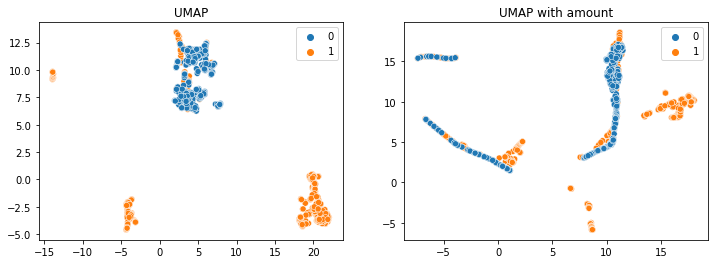

In [13]:
plt.figure(figsize=(12, 4))

ax=plt.subplot(121)
sns.scatterplot(x=card_umap[:, 0], y=card_umap[:, 1], hue = y_undersample.values.ravel())
plt.title("UMAP")

ax=plt.subplot(122)
sns.scatterplot(x=card_umap_wA[:, 0], y=card_umap_wA[:, 1], hue = y_undersample.values.ravel())
plt.title("UMAP with amount")

### amountデータを使わなければ、UMAPのみである程度の不正検出は可能そうである。

## UMAP（アンダーサンプルしない場合の分類）

In [14]:
X_wA=X.drop(['Time'],axis=1)
X=X.drop(['Time','Amount'],axis=1)

In [15]:
card_umap_ori=umap.UMAP(n_components=2).fit_transform(X[:4000])
card_umap_ori_wA=umap.UMAP(n_components=2).fit_transform(X_wA[:4000])

Text(0.5, 1.0, 'UMAP with amount')

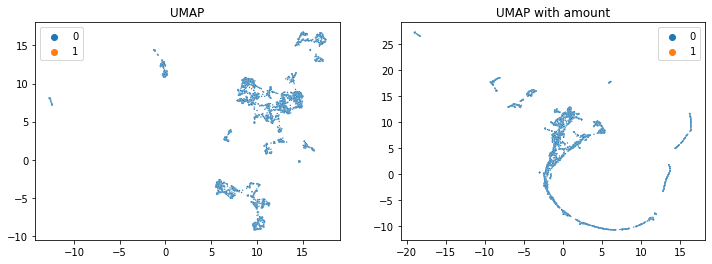

In [16]:
plt.figure(figsize=(12, 4))

ax=plt.subplot(121)
sns.scatterplot(x=card_umap_ori[:, 0], y=card_umap_ori[:, 1], hue = y[:4000].values.ravel(),s=2)
plt.title("UMAP")

ax=plt.subplot(122)
sns.scatterplot(x=card_umap_ori_wA[:, 0], y=card_umap_ori_wA[:, 1], hue = y[:4000].values.ravel(),s=2)
plt.title("UMAP with amount")

### グラフ表示状の問題であるが、アンダーサンプルをしない場合は陽性（不正）データがどこにあるのか分からない。

## PCA

In [17]:
# sklearnの標準化メソッドをインポート
from sklearn.preprocessing import StandardScaler

# 標準化の実行
sc = StandardScaler() # インスタンスを生成･定義
sc.fit(X_undersample)            # データ変換の計算式を生成
X_us_std = sc.transform(X_undersample)  # 実際にデータを変換

print("標準化得点：\n",X_us_std )
print(" ")
print("行列の形状：", X_us_std .shape)

標準化得点：
 [[ 0.01563645  0.03161543  0.29576535 ...  0.27956123  0.16698355
  -0.42426283]
 [-0.11783001 -1.3674806   0.72827977 ... -0.3952031  -0.34652869
  -0.00375394]
 [ 0.01725652 -0.02116444  0.49614565 ... -1.22459602 -0.05442047
  -0.44716937]
 ...
 [ 0.62936642 -0.57521636  0.6202992  ... -0.53019456 -0.03385711
  -0.06155958]
 [ 0.77417131 -0.67852863  0.45381496 ... -1.60584537 -0.07676145
  -0.12527976]
 [ 0.69049325 -0.71506135  0.55578222 ...  1.80346607 -0.14451552
  -0.07944641]]
 
行列の形状： (984, 28)


In [18]:
from sklearn.decomposition import PCA

# 主成分分析のモデルを生成
pca = PCA() # インスタンスを生成･定義
pca.fit(X_us_std)

PCA()

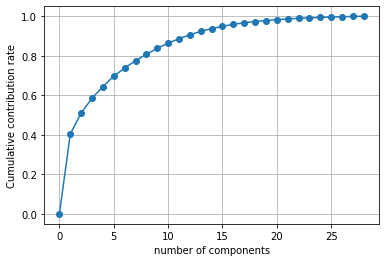

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28
累積寄与率,0.404625,0.510328,0.585665,0.643986,0.697349,0.737336,0.77532,0.8074,0.838107,0.863403,...,0.978462,0.982711,0.986398,0.989575,0.991904,0.994068,0.996024,0.997623,0.998974,1.0


In [21]:
# 寄与率の取得
evr =pca.explained_variance_ratio_

# 行名･列名を付与してデータフレームに変換
pd.DataFrame(evr, 
             index=["PC{}".format(x + 1) for x in range(len(X_undersample.columns))], 
             columns=["寄与率"])

# 起点0と寄与率の累積値をプロット
plt.plot([0] + list(np.cumsum(evr)), "-o")

plt.xlabel("number of components")
plt.ylabel("Cumulative contribution rate")

plt.grid()
plt.show()

# 累積寄与率
t_ev = pd.DataFrame(pca.explained_variance_ratio_.cumsum(), index=["PC{}".format(x + 1) for x in range(len(X_undersample.columns))], columns=['累積寄与率']).T
display(t_ev)

In [22]:
pca_Xus = pca.fit_transform(X_us_std)
print(pca_Xus.shape)
pca_Xus[:5]

(984, 28)


array([[ 1.30022175e-01, -2.88997924e-01, -4.45325428e-01,
         1.97914282e-01, -1.39661030e-01,  1.77038503e-01,
         3.23103319e-01,  4.22607658e-01,  8.84294666e-01,
        -1.81628269e-01,  2.88402540e-01,  5.78112085e-01,
         1.13475129e-02,  7.62063342e-02,  5.81877623e-01,
        -4.53527901e-01, -1.40497061e-02, -1.76255566e-03,
        -2.40723078e-01, -2.11681833e-01,  3.05445765e-01,
        -2.71498618e-01, -7.32598226e-02,  9.48167755e-02,
        -3.88324028e-01, -1.33183766e-01,  2.09870948e-02,
        -1.78685295e-02],
       [-2.01801253e+00,  5.34191956e-01, -4.16206018e-01,
         4.18199127e-01, -3.17838734e-01, -2.06681560e+00,
        -1.46667718e-02, -1.36964033e+00, -9.45651424e-02,
        -6.22387119e-01,  1.35326872e+00,  5.71255282e-01,
        -3.86934016e-01,  1.00585069e+00, -3.20345619e-01,
        -5.08212566e-01, -3.35640975e-01,  9.80873158e-01,
        -8.27374243e-01,  5.19872078e-01, -1.88331220e-01,
         9.72837193e-02, -3.11

Text(0.5, 1.0, 'After PCA')

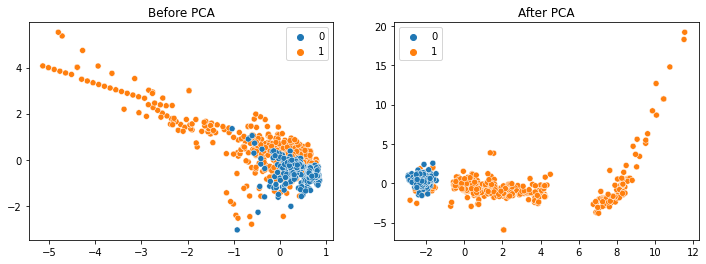

In [24]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
ax = sns.scatterplot(x=X_us_std[:,0],y=X_us_std[:,1],hue=y_undersample.values.ravel())
plt.title('Before PCA')

ax2 = fig.add_subplot(122)
ax2 = sns.scatterplot(x=pca_Xus[:,0],y=pca_Xus[:,1],hue=y_undersample.values.ravel())
plt.title('After PCA')

[(-3.0, 4.0), (-4.0, -1.0)]

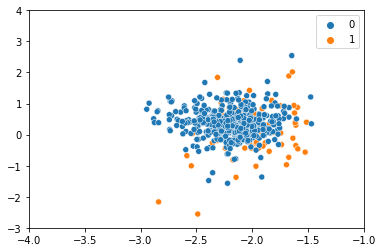

In [25]:
sns.scatterplot(x=pca_Xus[:,0],y=pca_Xus[:,1],hue=y_undersample.values.ravel()).set(ylim=(-3,4), xlim=(-4,-1))

### 主成分１が-1.0以上であれば陽性（不正データ）、と言えそうである。

## TSVD

In [29]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD()
x_svd = svd.fit_transform(X_us_std)
x_svd[:5]
print(x_svd.shape)

(984, 2)


In [27]:
svd.explained_variance_ratio_

array([0.40462544, 0.10570256])

Text(0.5, 1.0, 'After TSVD')

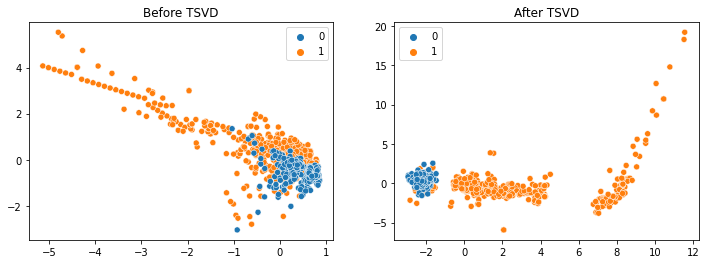

In [30]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
ax = sns.scatterplot(x=X_us_std[:,0],y=X_us_std[:,1],hue=y_undersample.values.ravel())
plt.title('Before TSVD')

ax2 = fig.add_subplot(122)
ax2 = sns.scatterplot(x=x_svd[:,0],y=x_svd[:,1],hue=y_undersample.values.ravel())
plt.title('After TSVD')

### 主成分分析とほぼ同様の結果

## tSNE（PCAデータを使用）

In [32]:
from sklearn.manifold import TSNE

x_tsne = TSNE(learning_rate=200,random_state=0).fit_transform(pca_Xus)
x_tsne[:5]

array([[-19.484905 ,  11.689586 ],
       [ 11.182816 , -24.417858 ],
       [-15.673205 ,   2.9818642],
       [-32.442078 ,  20.905397 ],
       [-20.775    ,  -8.385843 ]], dtype=float32)

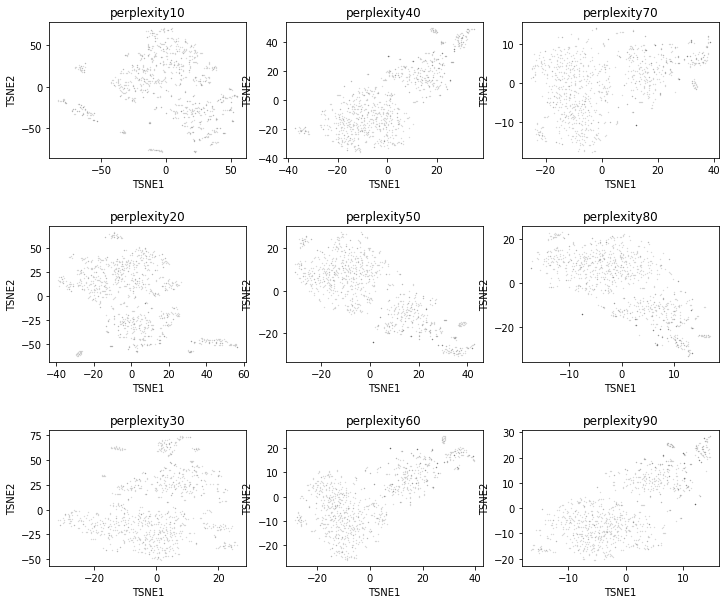

In [34]:
plotx = pca_Xus.copy()
ps = [10,20,30,40,50,60,70,80,90]

fig,ax = plt.subplots(3,3, figsize=(12,10))
plt.subplots_adjust(hspace=.5)
import math

# the search for ideal perplexity

for  i,perplexity in enumerate(ps):
    tsne = TSNE(n_components=2, perplexity=perplexity)
    tsneComponents =tsne.fit_transform(plotx)
    TSNE_Components = pd.DataFrame(tsneComponents, index=X_undersample.index)
    
    ax[i%3][math.floor(i/3)].set_title(f'perplexity{perplexity}')#.floor切り下げ
    ax[i%3][math.floor(i/3)].scatter(TSNE_Components[0], TSNE_Components[1],alpha=.2, color='black', s=0.1)
    ax[i%3][math.floor(i/3)].set(xlabel = 'TSNE1')
    ax[i%3][math.floor(i/3)].set(ylabel = 'TSNE2')

### perplexity = 40を選択（感覚で）

In [39]:
x_tsne = TSNE(n_components=2, perplexity=40).fit_transform(pca_Xus)
x_tsne[:5]

array([[-23.669222  ,  -0.71783084],
       [  8.815542  ,  12.757948  ],
       [-20.14377   ,  -2.827176  ],
       [-35.584175  ,   6.187295  ],
       [-20.409609  , -20.677143  ]], dtype=float32)

Text(0.5, 1.0, 'after tSNE')

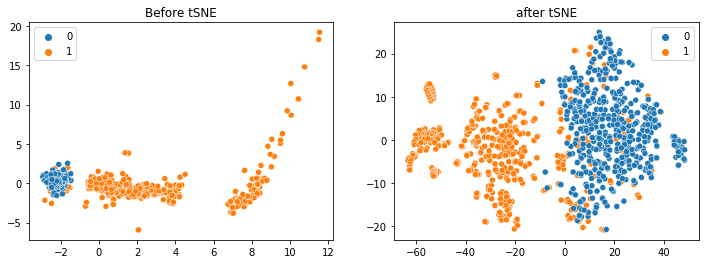

In [40]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
ax = sns.scatterplot(x=x_svd[:,0],y=x_svd[:,1],hue=y_undersample.values.ravel())
plt.title('Before tSNE')

ax2 = fig.add_subplot(122)
ax2 = sns.scatterplot(x=x_tsne[:,0],y=x_tsne[:,1],hue=y_undersample.values.ravel())
plt.title('after tSNE')

### PCAのみに比べどの程度精度が変わるかは不明だが、第一成分が-5以下であれば不正と言えそうである。

## 教師あり学習
K Foldで訓練データとテストデータに分ける
https://blog.amedama.jp/entry/2018/06/21/235951

In [42]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4,shuffle=True, random_state=True)
for train_index, test_index in kf.split(X_undersample, y_undersample):
    x_train_df = X_undersample.iloc[train_index]
    y_train_df = y_undersample.iloc[train_index]
    x_test_df = X_undersample.iloc[test_index]
    y_test_df = y_undersample.iloc[test_index]
    print("train_index:", train_index, "test_index:", test_index)

train_index: [  0   1   4   5   7   9  10  11  14  15  16  18  20  21  22  23  24  25
  26  27  28  29  30  31  32  33  36  37  38  39  40  42  43  44  45  46
  48  49  51  52  53  54  55  57  58  61  62  63  64  66  67  68  69  70
  71  72  74  75  76  77  79  80  82  83  86  87  88  89  91  92  93  95
  96  97  98 100 102 103 105 106 107 109 110 112 113 114 115 116 118 121
 122 123 124 126 127 128 129 130 131 132 134 136 137 138 139 140 141 143
 144 145 146 147 149 150 151 152 153 155 157 158 161 162 163 164 165 166
 167 168 169 170 171 172 173 174 176 178 179 182 183 184 185 187 188 190
 192 193 196 197 198 199 202 203 204 206 208 209 210 211 212 213 214 215
 217 218 219 220 221 222 224 225 226 227 229 230 231 232 234 235 237 239
 240 243 245 246 247 249 251 252 253 254 256 257 259 260 261 263 264 265
 266 269 270 271 272 273 275 276 277 278 279 280 281 282 283 284 285 286
 287 288 289 290 291 292 293 294 295 296 297 299 300 301 302 303 304 305
 308 310 312 313 315 316 317 319 321 3

In [45]:
print(type(train_index))
print(train_index.shape)
print(train_index)

<class 'numpy.ndarray'>
(738,)
[  0   1   2   3   4   5   6   8   9  11  12  13  14  16  17  18  19  23
  24  27  29  30  31  33  34  35  36  38  39  40  41  42  44  45  46  47
  49  50  51  52  53  54  56  57  58  59  60  61  62  65  66  67  68  69
  70  73  74  76  78  79  80  81  82  83  84  85  88  89  90  91  92  93
  94  95  97  98  99 100 101 102 103 104 105 106 107 108 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 127 128 131 132 133 134
 135 138 139 142 143 145 146 147 148 150 153 154 156 157 158 159 160 161
 162 163 164 165 167 168 169 171 172 173 174 175 177 179 180 181 182 184
 185 186 187 188 189 191 192 194 195 197 200 201 202 203 204 205 206 207
 208 211 213 214 216 217 218 220 221 223 224 225 226 227 228 229 230 232
 233 236 237 238 239 240 241 242 244 245 246 247 248 249 250 251 255 256
 257 258 259 260 261 262 265 267 268 270 271 272 273 274 275 277 280 283
 284 285 286 289 290 291 292 293 294 295 298 299 300 301 304 305 306 307
 308 309 310 311 312

In [46]:
print(y_undersample)

        Class
541         1
623         1
4920        1
6108        1
6329        1
...       ...
53249       0
200837      0
237989      0
53667       0
126352      0

[984 rows x 1 columns]


In [47]:
print(x_train_df.shape)
print(y_train_df.shape)
print(x_test_df.shape)
print(y_test_df.shape)

(738, 28)
(738, 1)
(246, 28)
(246, 1)


In [48]:
y_train_df[5:]

,Class
6331,1
6334,1
6338,1
6427,1
6472,1
...,...
53249,0
200837,0
237989,0
53667,0


## ロジスティック回帰 

In [49]:
lr = LogisticRegression(C = 10, penalty = 'l2')
lr.fit(x_train_df,y_train_df.values.ravel())
lr.score(x_test_df,y_test_df.values.ravel())

0.9146341463414634

In [50]:
y_pred = lr.predict(x_test_df.values)
print(recall_score(y_test_df,y_pred))

0.9180327868852459


In [51]:
precision_score(y_test_df,y_pred)

0.9105691056910569

In [52]:
scoring = {
        'acc': 'accuracy',
        'auc': 'roc_auc',
    }

In [53]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(shuffle=True)

In [54]:
from sklearn.model_selection import cross_validate
scores = cross_validate(lr, X_undersample, y_undersample, cv=skf, scoring=scoring)

In [55]:
print('Accuracy (mean):', scores['test_acc'].mean())
print('AUC (mean):', scores['test_auc'].mean())

Accuracy (mean): 0.9410597741634724
AUC (mean): 0.9757596792582216


In [56]:
LR_grid = {LogisticRegression(): {"C": [10 ** i for i in range(-5, 6)],
                                  "random_state": [i for i in range(0, 50)]}}

In [58]:
max_score = 0
score=0

for model, param in LR_grid.items():
    clf = GridSearchCV(model, param)
    clf.fit(x_train_df, y_train_df.values.ravel())
    pred_y = clf.predict(x_test_df)
    score=clf.score(x_test_df,y_test_df.values.ravel()) 
    pr=precision_score(y_test_df.values.ravel(),pred_y)
    re=recall_score(y_test_df.values.ravel(),pred_y)
    #Fscore
    score= 2*pr*re/(pr+re)
    print(score)
    if max_score < score:
        max_score = score
        best_param = clf.best_params_
        best_model = model.__class__.__name__
        
max_score

0.9372384937238495


0.9372384937238495

In [59]:
print(best_param)

{'C': 0.1, 'random_state': 0}


In [60]:
print(best_model)

LogisticRegression


### L2正則化の値=0.1, random_state =0の時に最も高いスコア（F値=0.937）が示された。

## PCAデータでランダムフォレスト（教師あり学習）

### グリッドサーチのために、バリデーションデータを作成する

In [45]:
T_size=180 #テスト及びバリデーションのサイズ

#x0_labels = np.zeros((x0.shape[0], 1), dtype=int)
x0_trainV, x_test, y0_trainV, y_test = train_test_split(X_undersample, y_undersample, test_size=T_size)
x_train, x_val, y_train, y_val = train_test_split(x0_trainV, y0_trainV, test_size=T_size)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)


(624, 28)
(624, 1)
(180, 28)
(180, 1)
(180, 28)
(180, 1)


In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

pca_comp = [1,3, 5, 10, 15, 20]
depth = [2, 3, 4, 5, 6, 7]
leaf = [1, 3, 5, 7, 10]
best_val_score = 0
best_param = {}

for i in pca_comp:
    for ｊ in depth:
        for k in leaf:
            pcan = PCA(n_components=i)
            train_pca = pcan.fit_transform(x_train)
            val_pca = pcan.transform(x_val)
            #print(i,"成分時の分散説明率（寄与率）",pca.explained_variance_ratio_)
            forest = RandomForestClassifier(n_estimators=10, max_depth=j, min_samples_leaf=k, random_state=0)
            scores = cross_val_score(forest, val_pca, y_val, cv=5)
            mean_score = np.mean(scores)
            if mean_score > best_val_score:
                best_val_score = mean_score
                best_param = {'max_comp': i, 'max_depth': j, "min_samples_leaf":k}

# out[best_val_score: 0.900]
# out[best_param:  {''max_comp': 20, 'max_depth': 4, 'min_samples_leaf': 7}]
print('best_val_score: {:0.3f}'.format(best_val_score))
print('best_param: ', best_param)

best_val_score: 0.967
best_param:  {'max_comp': 10, 'max_depth': 5, 'min_samples_leaf': 3}


### 上記のグリッドサーチより、10成分の主成分分析、深さ5及び最低サンプル3のランダムフォレストの際に最も精度が高い（0.967）ことが示された

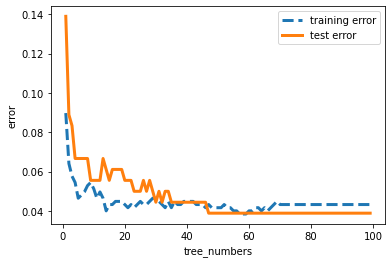

In [48]:
from sklearn.metrics import roc_curve#ROCは二分類のみ
from sklearn.metrics import roc_auc_score

pca10 = PCA(n_components=10)
train_pca = pca10.fit_transform(x_train)
test_pca = pca10.transform(x_test)

from sklearn import tree, ensemble

rf = ensemble.RandomForestClassifier(max_depth=5, min_samples_leaf=3,random_state=0)

list_nn = []
list_tr_score = []
list_te_score = []
for k in range(1,100): 
    rf.set_params(n_estimators=k)
    rf.fit(train_pca, y_train)
    #Y_pred = knc.predict(test_pca)#予測
    tr_score = rf.score(train_pca, y_train)
    te_score = rf.score(test_pca, y_test)#評価
    #print("[%d] score: {:.2f}".format(score) % k)
    list_nn.append(k)
    list_tr_score.append(1-tr_score)
    list_te_score.append(1-te_score)

plt.xlabel('tree_numbers')
plt.ylabel('error')
plt.plot(list_nn, list_tr_score,label='training error',linestyle='dashed',lw=3)
plt.plot(list_nn, list_te_score,label='test error',    linestyle='solid', lw=3)
plt.legend()
plt.show()



### 誤差4%程度に収束し、過学習は発生しなかった。

In [52]:
print(rf.predict(test_pca))

[1 0 1 1 0 0 1 0 1 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0
 1 1 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 1 1 1 0 0 0 0 1 1 0 0 1 0
 1 1 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 1 0
 0 1 1 1 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 1 1 1 0 1 0
 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 0 0 1 1 0 1]


In [84]:
ytest = y_test.to_numpy()
ytest[0:5]

array([[1],
       [0],
       [1],
       [1],
       [0]])

confusion matrix = 
[[92.  4.]
 [ 3. 81.]]
Misclassified cases : [5, 40, 53, 90, 122, 141, 143]
auc = 0.981


Text(0, 0.5, 'True positive fraction')

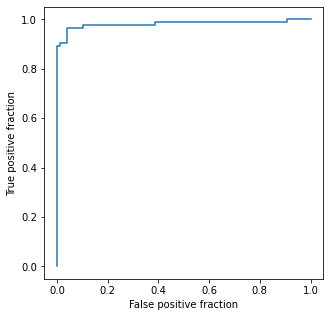

In [85]:
# 混同行列と分類失敗ケース(手計算)
cmat = np.zeros((2,2))
n = 0
failed = []
for y_true, y_pred in zip(ytest, rf.predict(test_pca)):
    cmat[int(y_true)][int(y_pred)] += 1##
    if (y_true != y_pred):
        failed.append(n)
    n += 1
print("confusion matrix = ")
print(cmat)
print("Misclassified cases :", failed)

# 混同行列 test data
cmat = np.zeros((2,2))
for y_true, y_pred in zip(ytest, rf.predict(test_pca)):
    cmat[int(y_true)][int(y_pred)] += 1

# 分類結果と確率
y_pred = rf.predict(test_pca)
prob = rf.predict_proba(test_pca)

fpf, tpf, thresholds = roc_curve(y_test, prob[:,1])#valデータで正解
auc = roc_auc_score(y_test, prob[:,1])#valデータで予測
"\n"
print("auc = {:.3f}".format(auc))

fig2,ax2 = plt.subplots(figsize=(5,5))
ax2.plot(fpf,tpf)
ax2.set_xlabel('False positive fraction')
ax2.set_ylabel('True positive fraction')

### auc=0.981と十分に高い性能が示された。但し、ランダムフォレストを使用できるのはアンダーサンプリング後のみであり、インバランスドデータには使えない点は留意が必要。